<a href="https://colab.research.google.com/github/RahulPatnaik/MRI/blob/main/MRI_Brain_scan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [29]:
print("OS Version & Details: ")
!lsb_release -a

OS Version & Details: 
No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 22.04.3 LTS
Release:	22.04
Codename:	jammy


In [30]:
import sys
import os
import math

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['figure.dpi'] = 300
%matplotlib inline
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import *

from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import *

print(f'Tensorflow Version: {tf.__version__}.')

Tensorflow Version: 2.15.0.


In [31]:
gpu_device_location = tpu_device_location = cpu_device_location = None

if os.environ['COLAB_GPU'] == '1':
    print("Allocated GPU Runtime Details:")
    !nvidia-smi
    print()
    try:
        import pynvml
        pynvml.nvmlInit()
        handle = pynvml.nvmlDeviceGetHandleByIndex(0)
        gpu_device_name = pynvml.nvmlDeviceGetName(handle)

        if gpu_device_name not in {b'Tesla T4', b'Tesla P4', b'Tesla P100-PCIE-16GB'}:
            raise Exception("Unfortunately this instance does not have a T4, P4 or P100 GPU.\nSometimes Colab allocates a Tesla K80 instead of a T4, P4 or P100.\nIf you get Tesla K80 then you can factory reset your runtime to get another GPUs.")
    except Exception as hardware_exception:
        print(hardware_exception, end = '\n\n')
    gpu_device_location = tf.test.gpu_device_name()
    print(f"{gpu_device_name.decode('utf-8')} is allocated sucessfully at location: {gpu_device_location}")
elif 'COLAB_TPU_ADDR' in os.environ:
    tpu_device_location = f"grpc://{os.environ['COLAB_TPU_ADDR']}"
    print(f"TPU is allocated successfully at location: {tpu_device_location}.")
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu_location)
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    tpu_strategy = tf.distribute.TPUStrategy()
else:
    cpu_device_location = "/cpu:0"
    print("GPUs and TPUs are not allocated successfully, hence runtime fallbacked to CPU.")

GPUs and TPUs are not allocated successfully, hence runtime fallbacked to CPU.


In [32]:
%%bash
RED_COLOR='\033[0;31m'
NO_COLOR='\033[0m'
pkg_name=tree
dpkg -s $pkg_name &> /dev/null
if [ "$?" -ne "0" ]
    then
        echo "Installing tree utility..."
        apt-get autoclean
        apt-get autoremove
        apt-get install $pkg_name
        if [ "$?" -eq "0" ]
            then
                echo -e ${RED_COLOR}"tree utility installed sucessfully.\n"${NO_COLOR}
        fi
    else
        echo "tree utility is already installed."
fi
tree --version

tree utility is already installed.
tree v2.0.2 (c) 1996 - 2022 by Steve Baker, Thomas Moore, Francesc Rocher, Florian Sesser, Kyosuke Tokoro 


In [33]:
!mkdir gdrive/MyDrive/Deep_Learning_Course_Project/
!mkdir gdrive/MyDrive/Deep_Learning_Course_Project/Brain-Tumor-Dataset/
!mkdir gdrive/MyDrive/Deep_Learning_Course_Project/Brain-Tumor-Dataset/Training/
!mkdir gdrive/MyDrive/Deep_Learning_Course_Project/Brain-Tumor-Dataset/Tumor-Mask/

In [48]:
!tree -d -C "gdrive/MyDrive/Deep_Course_Learning_Project"

gdrive/MyDrive/Deep_Course_Learning_Project
└── Brain-Tumor-Dataset
    ├── Brain-Tumor-Images-Mat-Files 
    ├── Testing
    │   ├── No
    │   └── Yes
    ├── Training
    │   ├── glioma
    │   ├── meningioma
    │   ├── no_tumor
    │   └── pituitary_tumor
    └── Tumor-Mask 
        ├── glioma
        ├── meningioma
        └── pituitary_tumor

14 directories


In [50]:
ROOT_DIR = r"gdrive/MyDrive/Deep_Course_Learning_Project/"
DATA_ROOT_DIR = os.path.join(ROOT_DIR, "Brain-Tumor-Dataset")
TRAIN_DIR = os.path.join(DATA_ROOT_DIR, 'Training')
MASK_DIR = os.path.join(DATA_ROOT_DIR, 'Tumor-Mask')
assert os.path.isdir(ROOT_DIR) and os.path.isdir(DATA_ROOT_DIR) and os.path.isdir(TRAIN_DIR) and os.path.isdir(MASK_DIR)
TUMOR_CLASS = ['meningioma', 'glioma', 'pituitary_tumor', 'no_tumor']
IMAGE_DATA_PATHS = [os.path.join(TRAIN_DIR, tumor_class) for tumor_class in TUMOR_CLASS]
MASK_DATA_PATHS = [os.path.join(MASK_DIR, tumor_name) for tumor_name in TUMOR_CLASS[:-1]]

In [40]:
!ls gdrive/MyDrive

'Adobe Scan 25-Oct-2023 (1).pdf'    IMG-20240329-WA0007.jpg
'Adobe Scan 25-Oct-2023.pdf'	    IMG-20240329-WA0008.jpg
'AI assignment  solver.gslides'     markai_accounts.gsheet
"Ammar's Apollo.gsheet"		    markai_accounts.xlsx
'Colab Notebooks'		    math-20230912T145443Z-002.zip
 Deep_Course_Learning_Project	    MRI_Brain_scan.ipynb
 gift				   'RAHUL PATNAIK - RVCE23BCD011 (3).pdf'
'gym bot zapier.gsheet'		   'RAHUL PATNAIK - RVCE23BCD011.pptx'
'ID card 25-Oct-2023 (2) (1).pdf'   sales_mark_ai.gsheet
'ID card 25-Oct-2023 (2).pdf'	    slackbot_ai.mp4
'ID card 25-Oct-2023 (3) (1).pdf'   tech_markai_accounts.gsheet
'ID card 25-Oct-2023 (3).pdf'	   'ufc bot.gsheet'
'IMG-20240329-WA0007 (1).jpg'	   'Untitled presentation.gslides'


In [41]:
!ls gdrive/MyDrive/Deep_Course_Learning_Project

'Brain-Tumor-Dataset '


In [45]:
!ls gdrive/MyDrive/Deep_Course_Learning_Project/Brain-Tumor-Dataset

'Brain-Tumor-Images-Mat-Files '   README.txt   Testing	 Training  'Tumor-Mask '


In [51]:
data_distribution_count = pd.Series([len(os.listdir(path)) for path in IMAGE_DATA_PATHS if os.path.exists(path) and os.path.isdir(path)],
                                    index = TUMOR_CLASS)
data_distribution_count

meningioma          708
glioma             1426
pituitary_tumor     930
no_tumor            395
dtype: int64

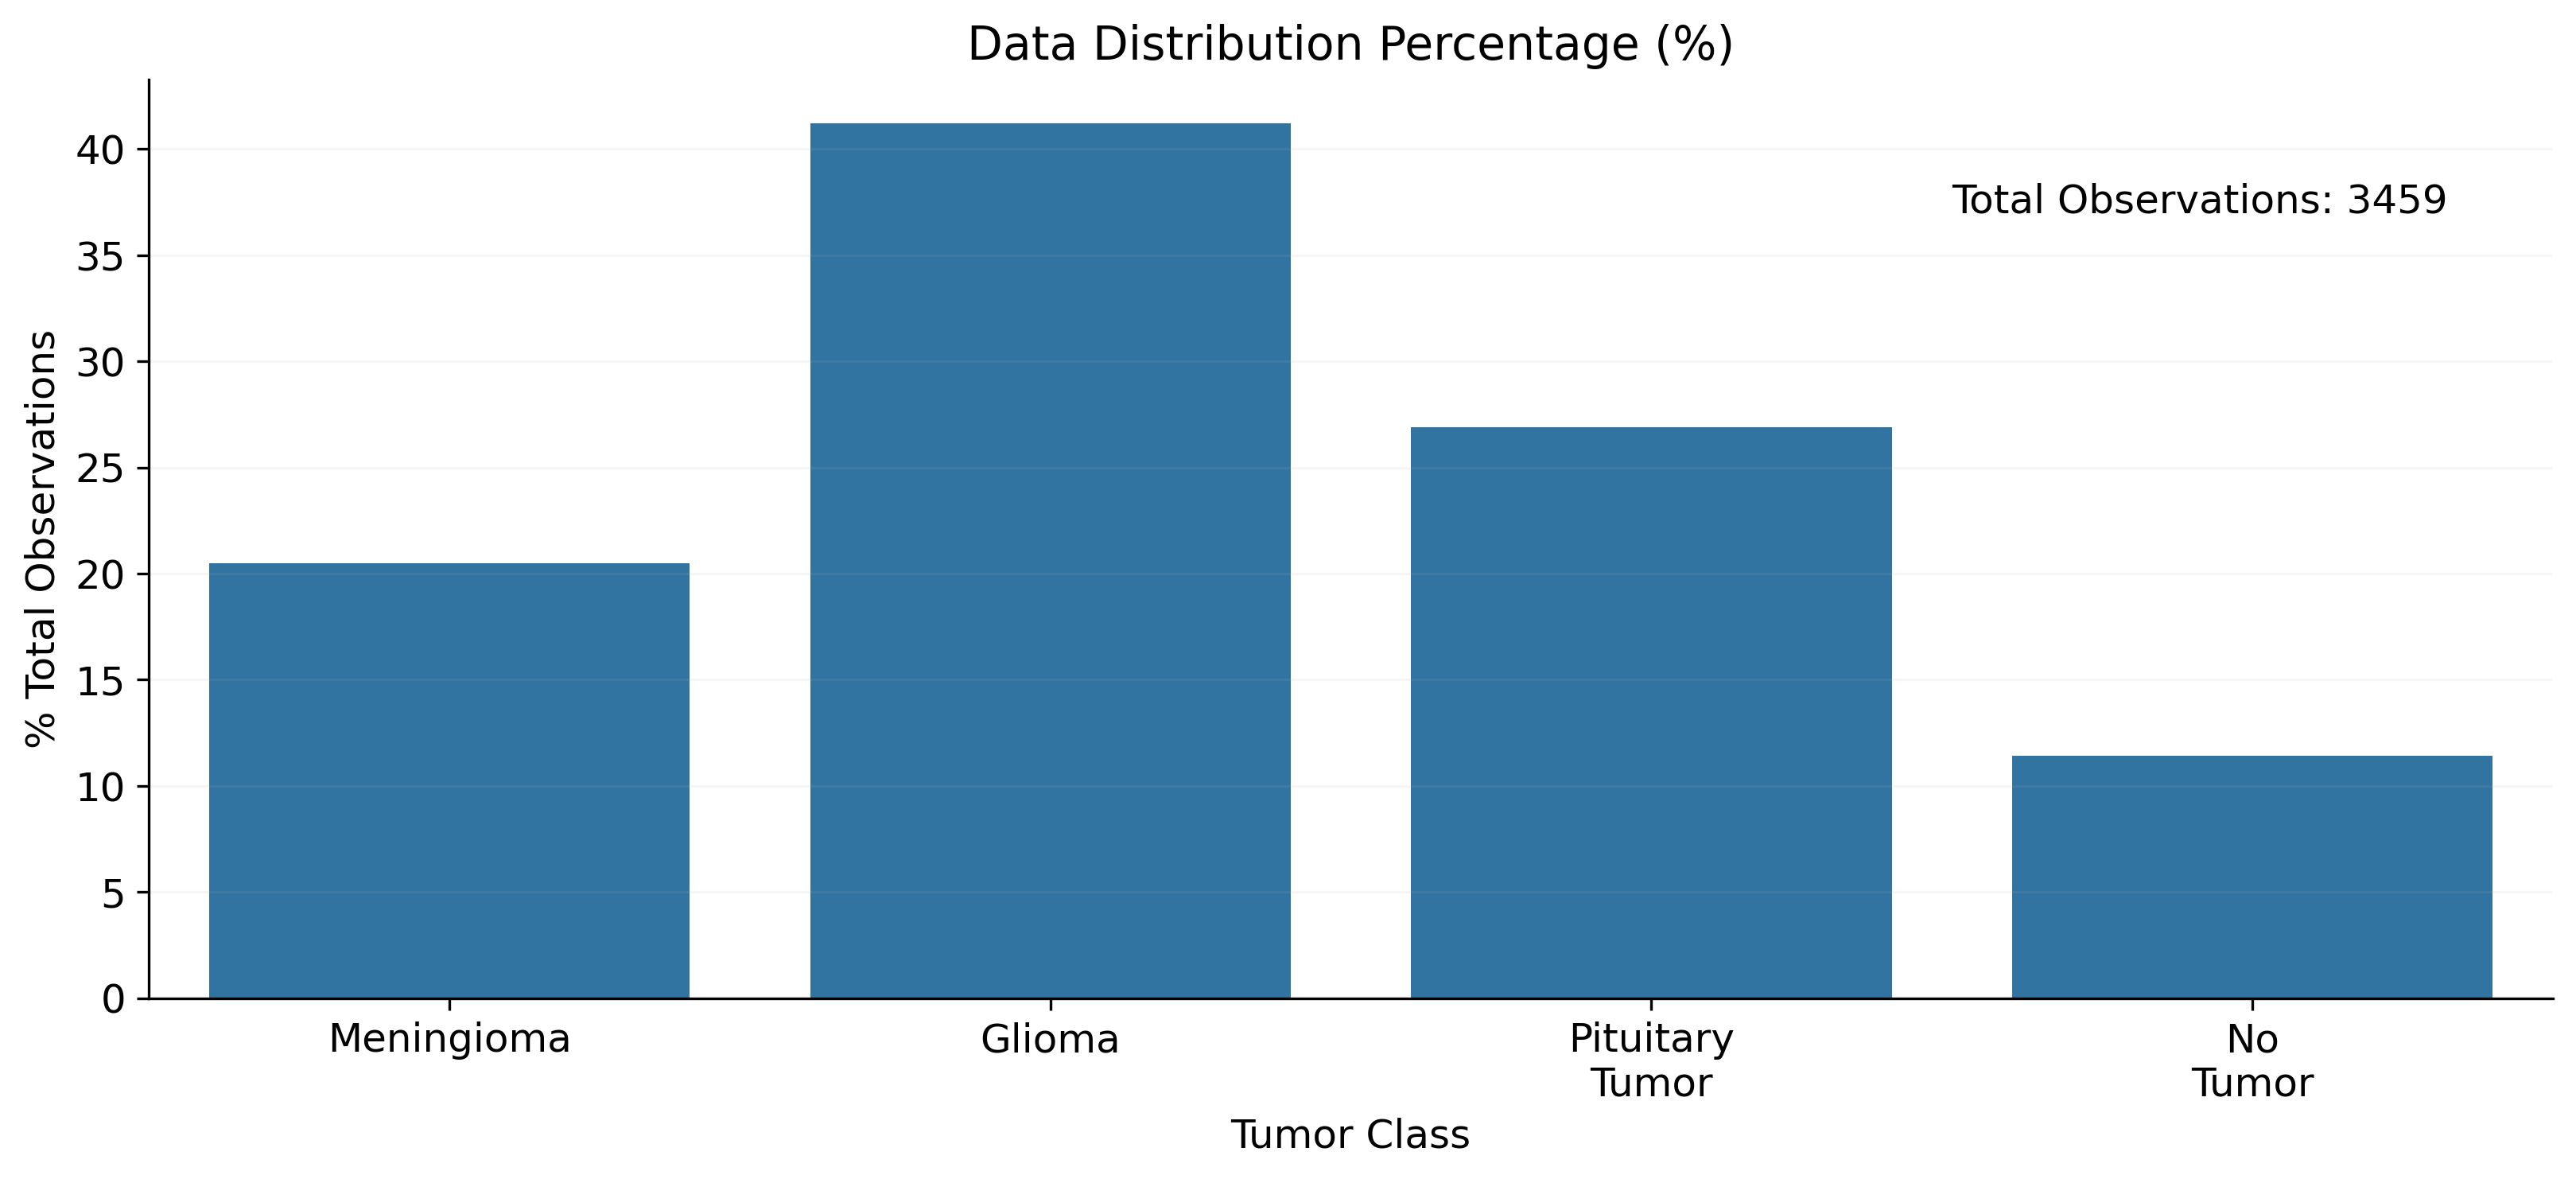

In [52]:
fig, axis = plt.subplots(figsize = (13, 5))
axis.grid(True, alpha = 0.1)
axis.set_title("Data Distribution Percentage (%)", fontsize = 14)
sns.barplot(x = ['\n'.join(curr_index.strip().split('_')).title() for curr_index in data_distribution_count.index],
            y = 100 * (data_distribution_count / data_distribution_count.sum()), ax = axis)
axis.set_xlabel("Tumor Class", fontsize = 12)
axis.set_ylabel("% Total Observations", fontsize = 12)
axis.tick_params(which = 'major', labelsize = 12)
axis.text(2.5, 37, f'Total Observations: {data_distribution_count.sum()}', fontdict = dict(size = 12))
sns.despine()

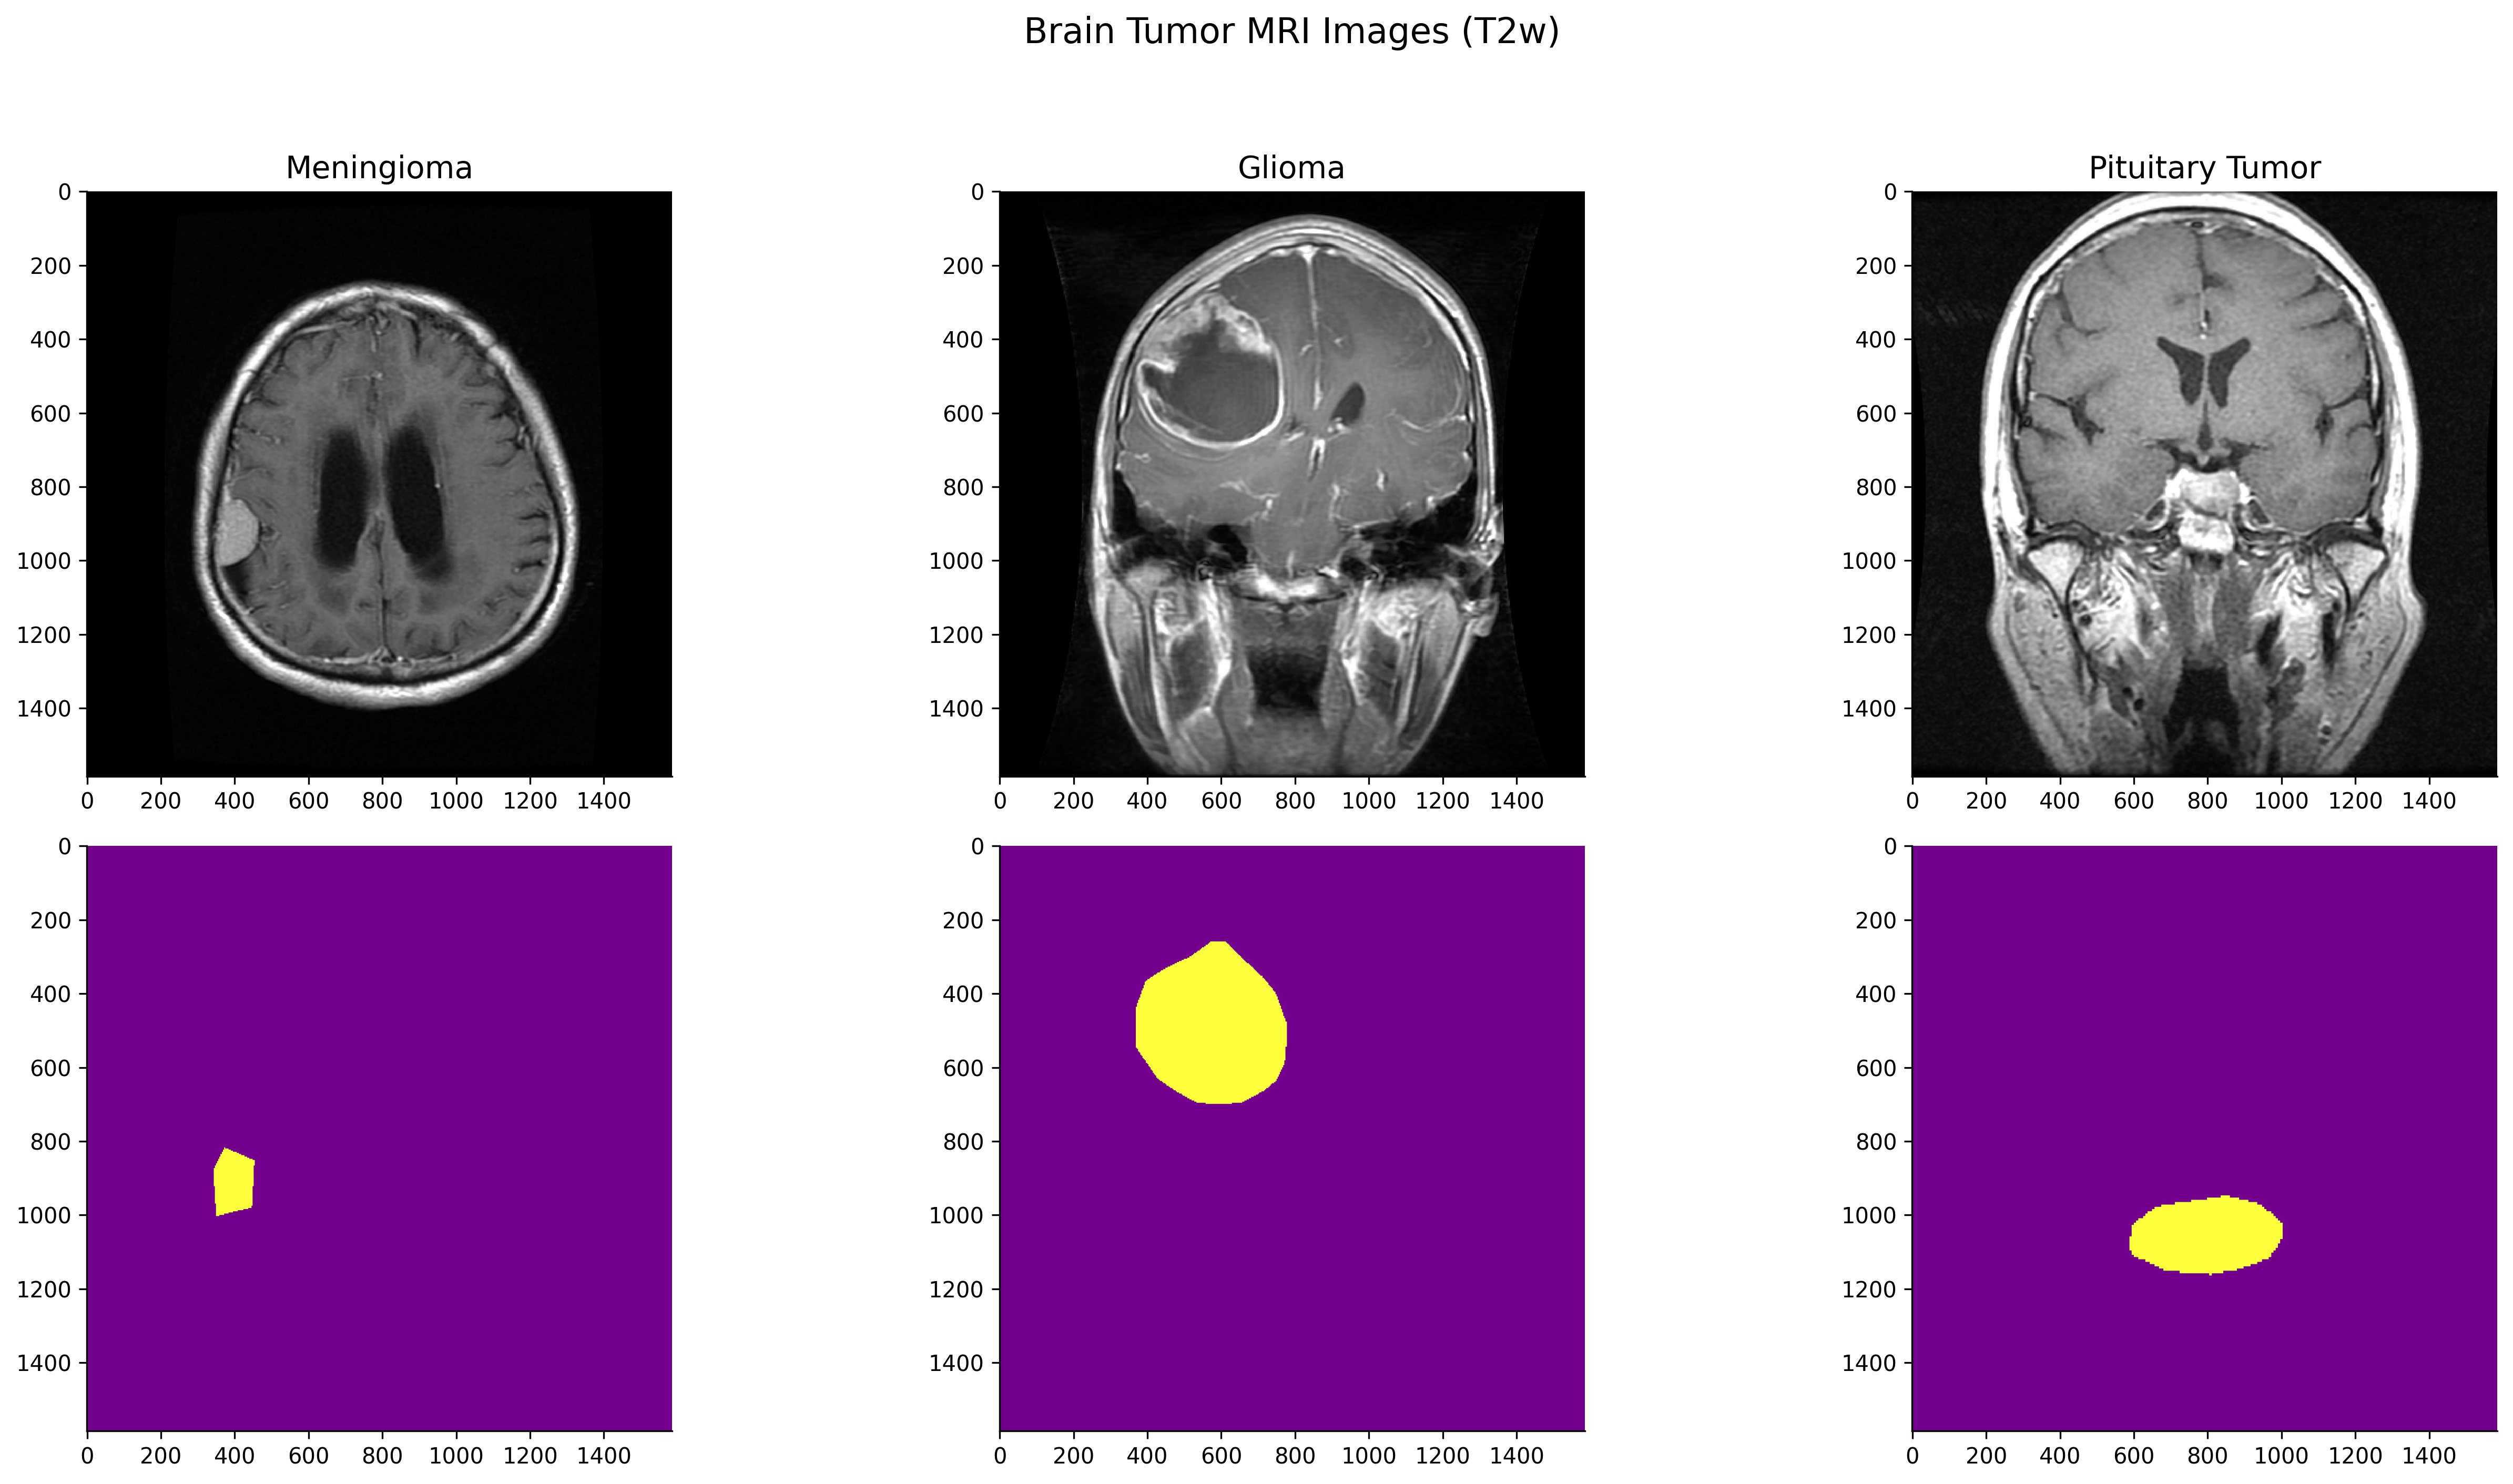

In [53]:
BRIGHTNESS_FACTOR = 1.7
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (18, 9))
axes = axes.flatten()
fig.suptitle("Brain Tumor MRI Images (T2w)", fontsize = 16, fontdict = dict(weight = 'bold'), y = 1.04)
for curr_title, filename, curr_axis in zip(TUMOR_CLASS[:-1], IMAGE_DATA_PATHS[:-1], axes[:3]):
    curr_image = Image.open(os.path.join(filename, os.listdir(filename)[2]))
    img_enhancer = ImageEnhance.Brightness(curr_image)
    curr_axis.imshow(img_enhancer.enhance(BRIGHTNESS_FACTOR))
    curr_axis.set_title(" ".join(curr_title.split('_')).title(), fontsize = 14)

for filename, curr_axis in zip(MASK_DATA_PATHS, axes[3:]):
    curr_image = Image.open(os.path.join(filename, os.listdir(filename)[2]))
    mask_enhancer = ImageEnhance.Brightness(curr_image)
    curr_axis.imshow(mask_enhancer.enhance(BRIGHTNESS_FACTOR))
fig.tight_layout()
sns.despine()

In [54]:
image_data_paths = []
for curr_path, tumor_name in zip(IMAGE_DATA_PATHS, TUMOR_CLASS):
    if os.path.exists(curr_path) and os.path.isdir(curr_path):
        image_data_paths.extend(map(lambda filename: (os.path.join(curr_path, filename), tumor_name), os.listdir(curr_path)))

In [55]:
image_data_paths_df = pd.DataFrame(image_data_paths, columns = ['image_filepaths', 'tumor_class']).sample(frac = 1, random_state = 42).reset_index(drop = True)
image_data_paths_df.head()

image_filepaths      tumor_class
0  gdrive/MyDrive/Deep_Course_Learning_Project/Br...       meningioma
1  gdrive/MyDrive/Deep_Course_Learning_Project/Br...       meningioma
2  gdrive/MyDrive/Deep_Course_Learning_Project/Br...  pituitary_tumor
3  gdrive/MyDrive/Deep_Course_Learning_Project/Br...  pituitary_tumor
4  gdrive/MyDrive/Deep_Course_Learning_Project/Br...  pituitary_tumor

In [56]:
image_data_paths_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3459 entries, 0 to 3458
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   image_filepaths  3459 non-null   object
 1   tumor_class      3459 non-null   object
dtypes: object(2)
memory usage: 54.2+ KB


In [57]:
intermediate_train_data, test_data = train_test_split(image_data_paths_df,
                                                      train_size = 0.70,
                                                      random_state = 42,
                                                      stratify = image_data_paths_df.tumor_class)

train_data, validation_data = train_test_split(intermediate_train_data,
                                               train_size = 0.80,
                                               random_state = 42,
                                               stratify = intermediate_train_data.tumor_class)

<ipython-input-58-b83b8717f719>:7: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  curr_axis.grid(False, alpha = 0.1)
<ipython-input-58-b83b8717f719>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  curr_axis.set_xticklabels(["\n".join(xtick.split("_")).title() for xtick in TUMOR_CLASS])


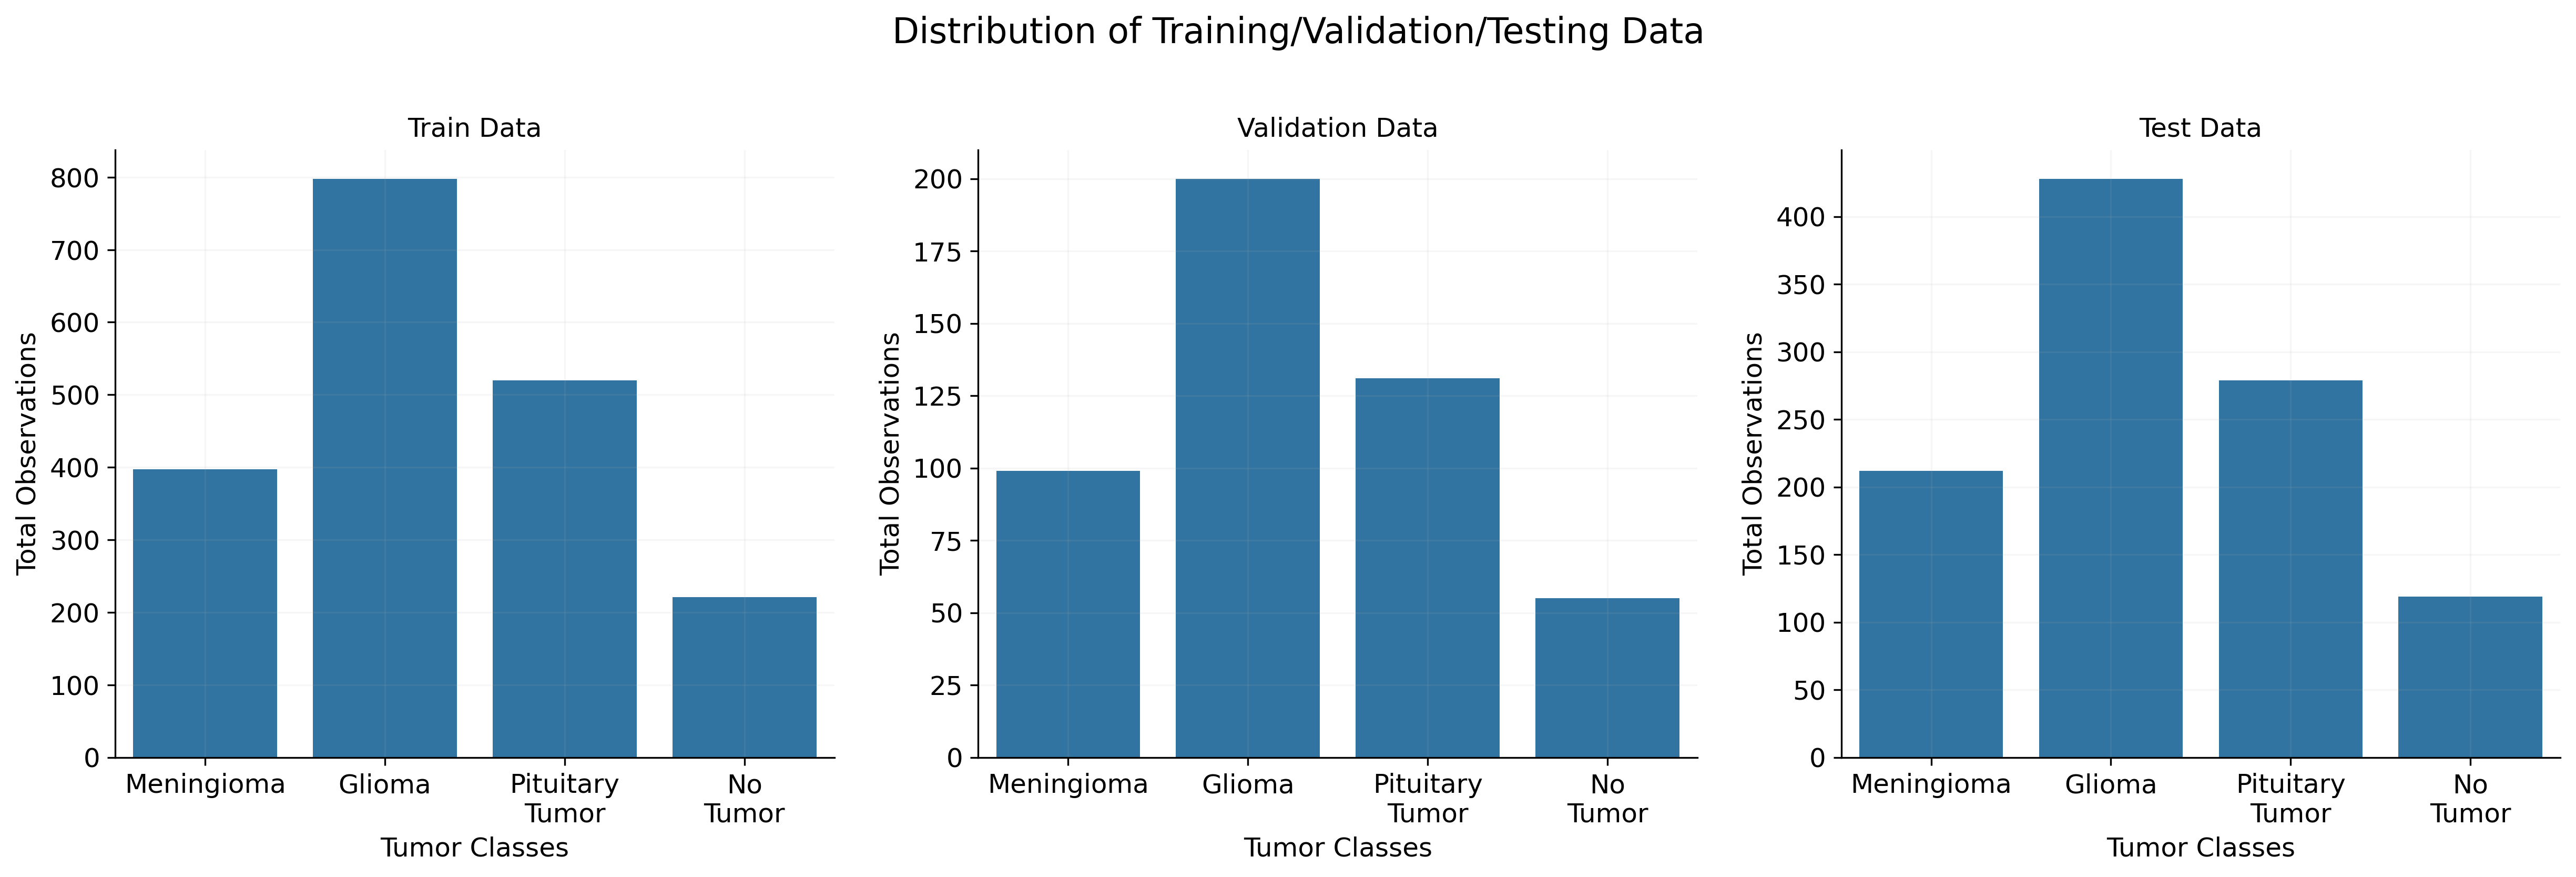

In [58]:
fig, axes = plt.subplots(ncols = 3, figsize = (20, 5))
fig.suptitle("Distribution of Training/Validation/Testing Data", fontsize = 16, fontdict = dict(weight = 'bold'), y = 1.05)
sns.countplot(x = train_data.tumor_class, order = TUMOR_CLASS, ax = axes[0])
sns.countplot(x = validation_data.tumor_class, order = TUMOR_CLASS, ax = axes[1])
sns.countplot(x = test_data.tumor_class, order = TUMOR_CLASS, ax = axes[2])
for curr_axis, curr_title in zip(axes, ['Train Data', 'Validation Data', 'Test Data']):
    curr_axis.grid(False, alpha = 0.1)
    curr_axis.set_title(curr_title, fontsize = 12)
    curr_axis.set_xlabel("Tumor Classes", fontsize = 12)
    curr_axis.set_ylabel("Total Observations", fontsize = 12)
    curr_axis.tick_params(which = 'major', labelsize = 12)
    curr_axis.set_xticklabels(["\n".join(xtick.split("_")).title() for xtick in TUMOR_CLASS])
sns.despine()

In [59]:
image_size = 128
batch_size = 32

image_datagen_kwargs = dict(rescale = 1 / 255,
                            rotation_range = 15,
                            width_shift_range = 0.1,
                            zoom_range = 0.01,
                            shear_range = 0.01,
                            brightness_range = [0.3, 1.5],
                            horizontal_flip = True,
                            vertical_flip = True)

In [60]:
train_image_datagen = ImageDataGenerator(**image_datagen_kwargs)
validation_image_datagen = ImageDataGenerator(**image_datagen_kwargs)
test_image_datagen = ImageDataGenerator(**image_datagen_kwargs)

In [61]:
train_dataset = train_image_datagen.flow_from_dataframe(train_data,
                                                        x_col = 'image_filepaths',
                                                        y_col = 'tumor_class',
                                                        seed = 42,
                                                        batch_size = batch_size,
                                                        target_size = (image_size, image_size),
                                                        color_mode = 'rgb')
validation_dataset = validation_image_datagen.flow_from_dataframe(validation_data,
                                                                  x_col = 'image_filepaths',
                                                                  y_col = 'tumor_class',
                                                                  seed = 42,
                                                                  batch_size = batch_size,
                                                                  target_size = (image_size, image_size),
                                                                  color_mode = 'rgb')
test_dataset = test_image_datagen.flow_from_dataframe(test_data,
                                                      x_col = 'image_filepaths',
                                                      y_col = 'tumor_class',
                                                      seed = 42,
                                                      batch_size = batch_size,
                                                      target_size = (image_size, image_size),
                                                      color_mode = 'rgb')

Found 1936 validated image filenames belonging to 4 classes.
Found 485 validated image filenames belonging to 4 classes.
Found 1038 validated image filenames belonging to 4 classes.


In [62]:
print("Information about Training Dataset:")
print(train_dataset.class_indices)
print(train_dataset.image_shape, end = '\n\n')

print("Information about Validation Dataset:")
print(validation_dataset.class_indices)
print(validation_dataset.image_shape, end = '\n\n')

print("Information about Testing Dataset:")
print(test_dataset.class_indices)
print(test_dataset.image_shape)

Information about Training Dataset:
{'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
(128, 128, 3)

Information about Validation Dataset:
{'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
(128, 128, 3)

Information about Testing Dataset:
{'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
(128, 128, 3)


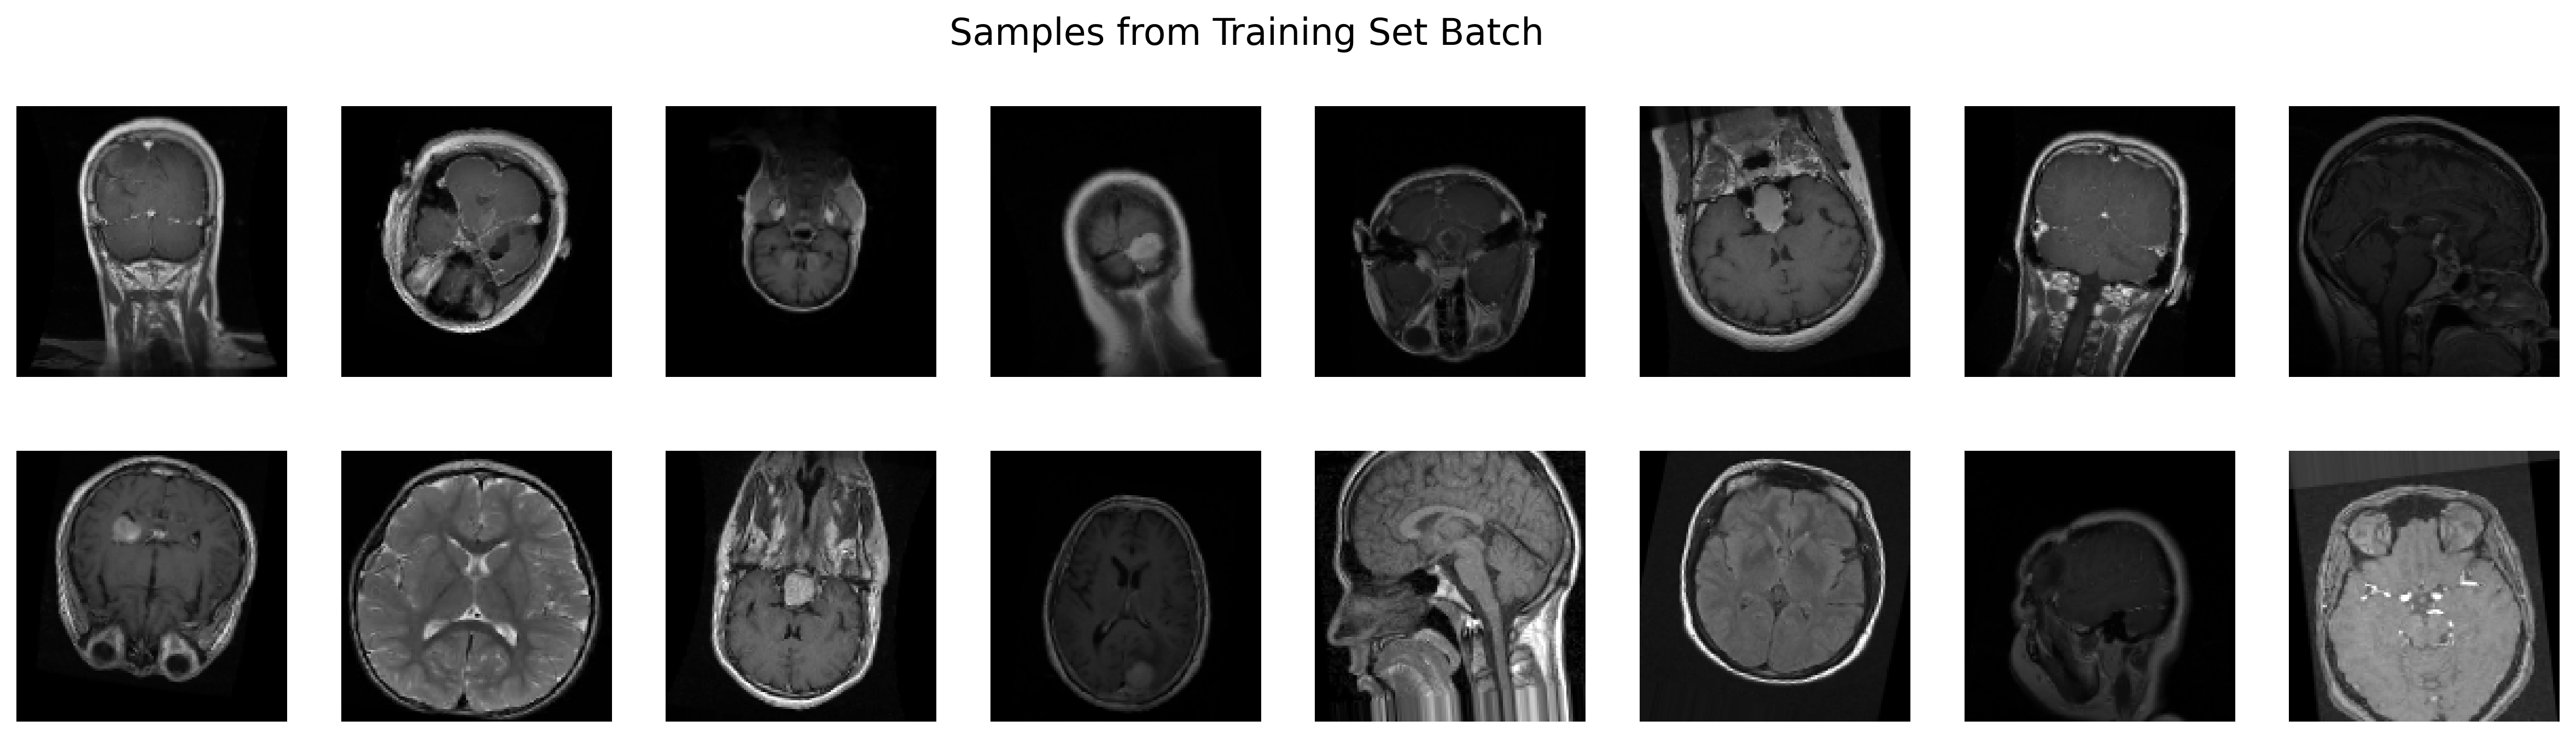

In [63]:
fig, axes = plt.subplots(nrows = 2, ncols = 8, figsize = (20, 5))
fig.suptitle("Samples from Training Set Batch", fontsize = 16, fontdict = dict(weight = 'bold'))
for curr_axis, curr_image in zip(axes.flatten(), train_dataset[0][0][:16]):
    curr_axis.imshow(tf.squeeze(curr_image), cmap = 'gray')
    curr_axis.axis(False)

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 8, figsize = (20, 5))
fig.suptitle("Samples from Validation Set Batch", fontsize = 16, fontdict = dict(weight = 'bold'))
for curr_axis, curr_image in zip(axes.flatten(), validation_dataset[0][0][:16]):
    curr_axis.imshow(tf.squeeze(curr_image), cmap = 'gray')
    curr_axis.axis(False)

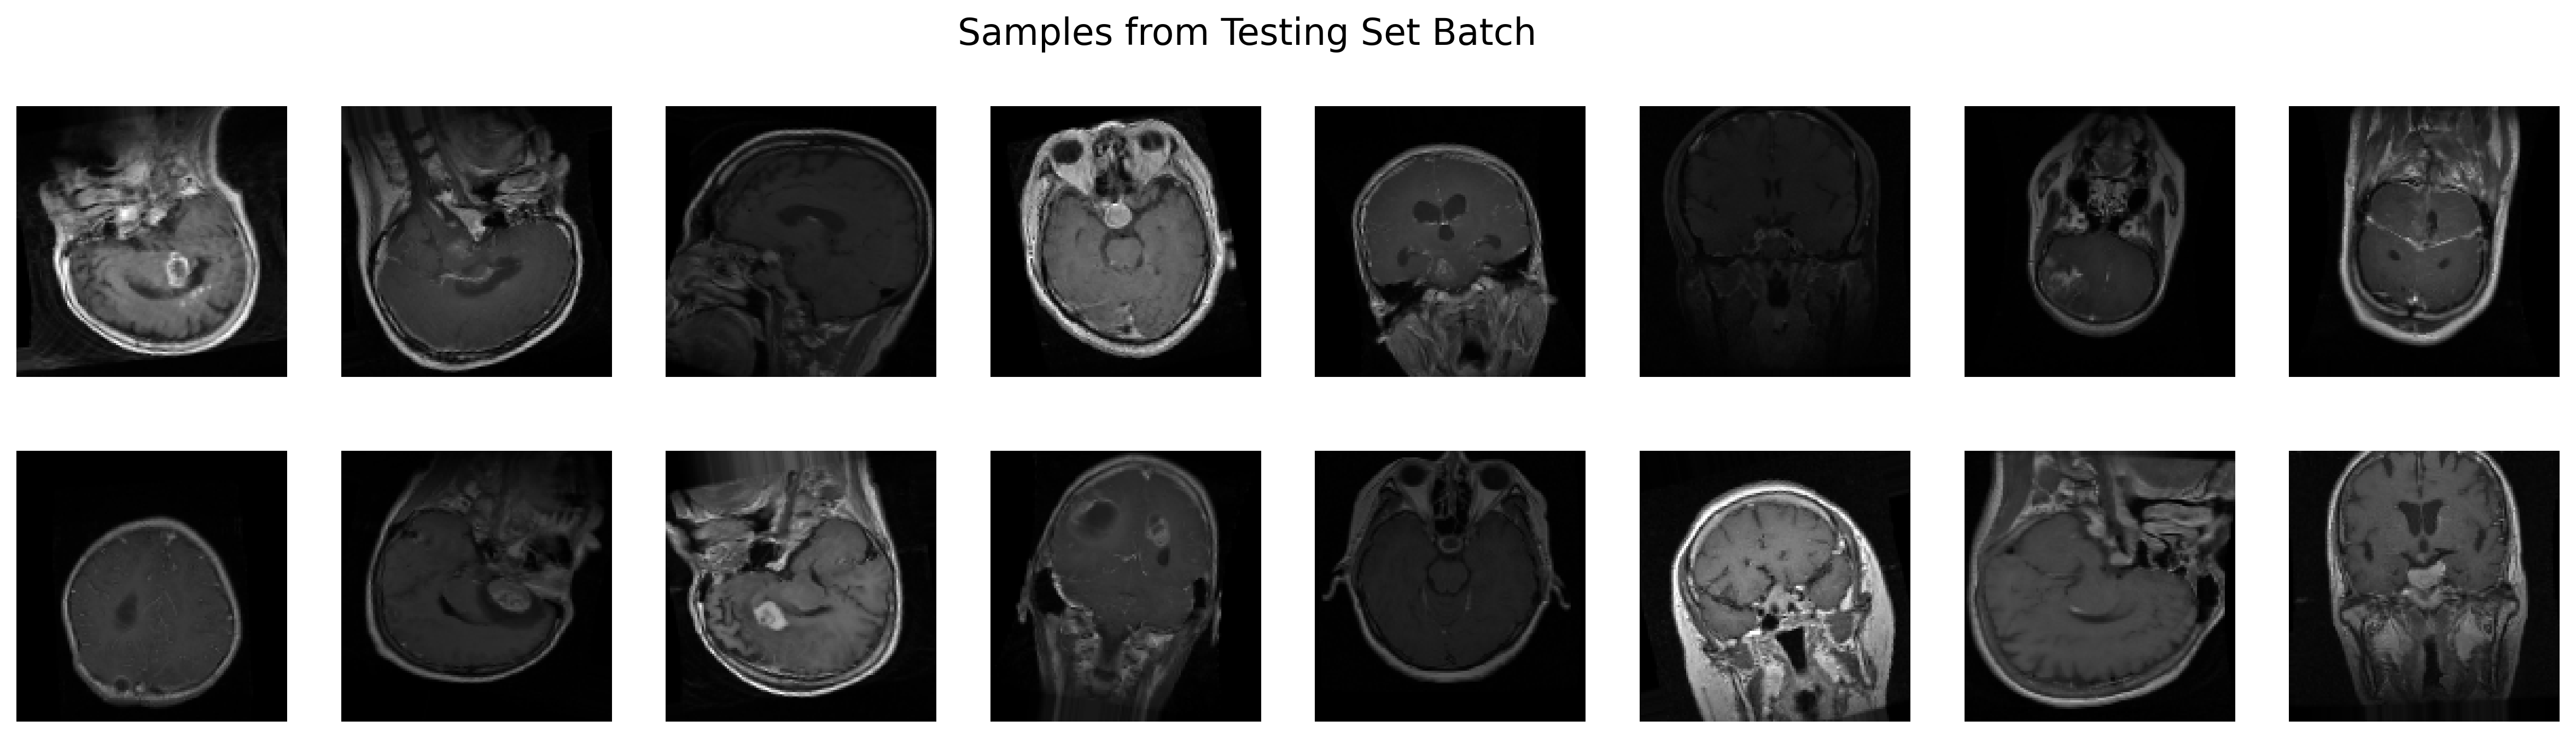

In [65]:
fig, axes = plt.subplots(nrows = 2, ncols = 8, figsize = (20, 5))
fig.suptitle("Samples from Testing Set Batch", fontsize = 16, fontdict = dict(weight = 'bold'))
for curr_axis, curr_image in zip(axes.flatten(), test_dataset[0][0][:16]):
    curr_axis.imshow(tf.squeeze(curr_image), cmap = 'gray')
    curr_axis.axis(False)

In [66]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 10)

In [68]:
ROOT_CHECKPOINT_DIR_PATH = os.path.join(ROOT_DIR, "Model-Checkpoints")
MLP_CHECKPOINT_DIR_PATH = os.path.join(ROOT_CHECKPOINT_DIR_PATH, "Multi-Layer-Perceptron")
ALEXNET_CHECKPOINT_DIR_PATH = os.path.join(ROOT_CHECKPOINT_DIR_PATH, "AlexNet-CNN")
INCEPTIONV3_CHECKPOINT_DIR_PATH = os.path.join(ROOT_CHECKPOINT_DIR_PATH, "InceptionV3")
os.makedirs(ROOT_CHECKPOINT_DIR_PATH, exist_ok=True)
os.makedirs(MLP_CHECKPOINT_DIR_PATH, exist_ok=True)
os.makedirs(ALEXNET_CHECKPOINT_DIR_PATH, exist_ok=True)
os.makedirs(INCEPTIONV3_CHECKPOINT_DIR_PATH, exist_ok=True)
assert os.path.isdir(ROOT_CHECKPOINT_DIR_PATH) and os.path.isdir(MLP_CHECKPOINT_DIR_PATH) and os.path.isdir(ALEXNET_CHECKPOINT_DIR_PATH) and os.path.isdir(INCEPTIONV3_CHECKPOINT_DIR_PATH)

In [69]:
mlp_cp_callback = ModelCheckpoint(MLP_CHECKPOINT_DIR_PATH,
                                  monitor = 'val_accuracy',
                                  verbose = 1,
                                  save_weights_only = True,
                                  save_freq =  'epoch')

alexnet_cp_callback = ModelCheckpoint(ALEXNET_CHECKPOINT_DIR_PATH,
                                      monitor = 'val_accuracy',
                                      verbose = 1,
                                      save_weights_only = True,
                                      save_freq = 'epoch')

inceptionv3_cp_callback = ModelCheckpoint(INCEPTIONV3_CHECKPOINT_DIR_PATH,
                                          monitor = 'val_accuracy',
                                          verbose = 1,
                                          save_weights_only = True,
                                          save_freq = 'epoch')

In [70]:
def training_process_viz(training_stats: pd.DataFrame, **plot_kwargs) -> None:
    fig, axes = plt.subplots(ncols = 2, figsize = (15, 5))
    fig.suptitle(plot_kwargs['plot_title'], fontsize = 16, fontdict = dict(weight = 'bold'), y = 1.08)
    for curr_axis, col_name in zip(axes, ['accuracy', 'loss']):
        curr_axis.grid(True, alpha = 0.3)
        curr_axis.set_title(f"Model {col_name}".title(), fontsize = 14)
        sns.lineplot(x = range(1, 1 + training_stats.shape[0]), y = training_stats[col_name], color = 'blue', ax = curr_axis)
        sns.lineplot(x = range(1, 1 + training_stats.shape[0]), y = training_stats[f"val_{col_name}"], color = 'red', ax = curr_axis)
        curr_axis.set_xlabel("Epochs", fontsize = 12)
        curr_axis.set_ylabel(col_name.title(), fontsize = 12)
        curr_axis.tick_params(which = 'major', labelsize = 12)
        curr_axis.legend([col_name.title(), f"validation {col_name}".title()], title = col_name.title())
    fig.tight_layout()
    sns.despine()

In [71]:
def confusion_matrix_viz(model, test_dataset, **plot_kwargs) -> None:
    assert isinstance(model, Sequential)
    model_preds = [np.argmax(curr_row) for curr_row in model.predict(test_dataset)]
    fig, axis = plt.subplots(figsize = (8, 6))
    class_names = ['Glioma', 'Meningioma', 'No-Tumor', 'Pituitary\nTumor']
    sns.heatmap(confusion_matrix(test_dataset.classes, model_preds), annot = True, cmap = plt.cm.Reds, ax = axis)
    axis.set_title(plot_kwargs['plot_title'], fontsize = 14)
    axis.tick_params(which = 'major', labelsize = 12)
    axis.set_xlabel("Pedicted Class", fontsize = 12)
    axis.set_ylabel("Actual Class", fontsize = 12)
    axis.set_xticklabels(class_names, fontdict = dict(fontsize = 12))
    axis.set_yticklabels(class_names, fontdict = dict(fontsize = 12))
    fig.tight_layout()
    sns.despine()

In [72]:
def generate_report(*models, test_dataset, row_indexes) -> pd.DataFrame:
    assert len(models)
    report_df = pd.DataFrame(columns = ['MAE', 'MSE', 'RMSE', 'Loss', 'Accuracy', 'F1-Score'])
    y_hat = test_dataset.classes # y_hat = ground_truth
    for curr_index, curr_model in enumerate(models):
        assert isinstance(curr_model, Sequential)
        curr_model_loss, curr_model_accuracy = curr_model.evaluate(test_dataset)
        y_preds = [np.argmax(curr_preds) for curr_preds in curr_model.predict(test_dataset)]
        report_df.loc[curr_index] = [mean_absolute_error(y_hat, y_preds), mean_squared_error(y_hat, y_preds), mean_squared_error(y_hat, y_preds, squared = False), curr_model_loss, curr_model_accuracy, f1_score(y_hat, y_preds, average = "micro")]
    report_df.index = row_indexes
    return report_df

In [73]:
mlp_model = Sequential()
mlp_model.add(Flatten(input_shape = (image_size, image_size, 3), name = 'Flatten-Layer'))
mlp_model.add(Dense(2048, activation = 'relu', name = 'Hidden-Layer-1'))
mlp_model.add(Dropout(rate = 0.2, name = 'Dropout-Layer-1'))
mlp_model.add(Dense(1024, activation = 'relu', name = 'Hidden-Layer-2'))
mlp_model.add(Dropout(rate = 0.2, name = 'Dropout-Layer-2'))
mlp_model.add(Dense(512, activation = 'relu', name = 'Hidden-Layer-3'))
mlp_model.add(Dropout(rate = 0.2, name = 'Dropout-Layer-3'))
mlp_model.add(Dense(4, activation = 'softmax', name = 'Output-Layer-1'))
mlp_model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Flatten-Layer (Flatten)     (None, 49152)             0         
                                                                 
 Hidden-Layer-1 (Dense)      (None, 2048)              100665344 
                                                                 
 Dropout-Layer-1 (Dropout)   (None, 2048)              0         
                                                                 
 Hidden-Layer-2 (Dense)      (None, 1024)              2098176   
                                                                 
 Dropout-Layer-2 (Dropout)   (None, 1024)              0         
                                                                 
 Hidden-Layer-3 (Dense)      (None, 512)               524800    
                                                                 
 Dropout-Layer-3 (Dropout)   (None, 512)               0

In [74]:
with tf.device(gpu_device_location) if gpu_device_location else tpu_strategy.scope() if tpu_device_location else tf.device(cpu_device_location):
    mlp_train_history = mlp_model.fit(train_dataset,
                                      batch_size = batch_size,
                                      validation_data = validation_dataset,
                                      epochs = 100,
                                      callbacks = [early_stopping])

Epoch 1/100
22/61 [=========>....................] - ETA: 8:14 - loss: 9.1902 - accuracy: 0.3295

KeyboardInterrupt: 

In [ ]:
training_process_viz(pd.DataFrame(mlp_train_history.history),
                     plot_title = 'Multilayer Perceptron Training Statistics')

In [ ]:
confusion_matrix_viz(mlp_model, train_dataset, plot_title = "MLP Confusion Matrix")

In [ ]:
mlp_report_df = generate_report(mlp_model,
                                test_dataset = test_dataset,
                                row_indexes = ("Multi-Layer-Perceptron Model",))
mlp_report_df

In [ ]:
alexnet_cnn = Sequential()
alexnet_cnn.add(Conv2D(96, kernel_size = 11, strides = 4, activation = 'relu', input_shape = (image_size, image_size, 3), name = 'Conv2D-1'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-1'))
alexnet_cnn.add(MaxPool2D(pool_size = 3, strides = 2, name = 'Max-Pooling-1'))
alexnet_cnn.add(Conv2D(256, kernel_size = 5, padding = 'same', activation = 'relu', name = 'Conv2D-2'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-2'))
alexnet_cnn.add(MaxPool2D(pool_size = 3, strides = 2, name = 'Max-Pooling-2'))
alexnet_cnn.add(Conv2D(384, kernel_size = 3, padding = 'same', activation = 'relu', name = 'Conv2D-3'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-3'))
alexnet_cnn.add(Conv2D(384, kernel_size = 3, padding = 'same', activation = 'relu', name = 'Conv2D-4'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-4'))
alexnet_cnn.add(Conv2D(256, kernel_size = 3, padding = 'same', activation = 'relu', name = 'Conv2D-5'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-5'))
alexnet_cnn.add(MaxPool2D(pool_size = 3, strides = 2, name = 'Max-Pooling-3'))
alexnet_cnn.add(Flatten(name = 'Flatten-Layer-1'))
alexnet_cnn.add(Dense(128, activation = 'relu', name = 'Hidden-Layer-1'))
alexnet_cnn.add(Dropout(rate = 0.5, name = 'Dropout-Layer-1'))
alexnet_cnn.add(Dense(64, activation = 'relu', name = 'Hidden-Layer-2'))
alexnet_cnn.add(Dropout(rate = 0.5, name = 'Dropout-Layer-2'))
alexnet_cnn.add(Dense(4, activation = 'softmax', name = 'Output-Layer'))
alexnet_cnn.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
alexnet_cnn.summary()


In [ ]:
with tf.device(gpu_device_location) if gpu_device_location else tpu_strategy.scope() if tpu_device_location else tf.device(cpu_device_location):
    alexnet_train_history = alexnet_cnn.fit(train_dataset,
                                            batch_size = batch_size,
                                            validation_data = validation_dataset,
                                            epochs = 100,
                                            callbacks = [early_stopping, alexnet_cp_callback])

In [ ]:
training_process_viz(pd.DataFrame(alexnet_train_history.history), plot_title = 'AlexNet CNN Training Stats')

In [ ]:
with tf.device(gpu_device_location) if gpu_device_location else tpu_strategy.scope() if tpu_device_name else tf.device(cpu_device_location):
    confusion_matrix_viz(alexnet_cnn,
                         test_dataset,
                         plot_title = "AlexNet CNN Confusion Matrix")

In [ ]:
alexnet_report_df = generate_report(alexnet_cnn, test_dataset = test_dataset, row_indexes = ['AlexNet CNN'])
alexnet_report_df

In [ ]:
inception_v3_model = InceptionV3(include_top = False,
                                 input_shape = (image_size, image_size, 3),
                                 pooling = 'avg')
inception_v3_model.trainable = False

In [ ]:
inception_cnn_model = Sequential()
inception_cnn_model.add(inception_v3_model)
inception_cnn_model.add(Flatten())
inception_cnn_model.add(Dense(1024, activation = 'relu', name = 'Hidden-Layer-1'))
inception_cnn_model.add(Dense(4, activation = 'softmax', name = 'Output-Layer'))
inception_cnn_model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
inception_cnn_model.summary()

In [ ]:
with tf.device(gpu_device_location) if gpu_device_location else tpu_strategy.scope() if tpu_device_location else tf.device(cpu_device_location):
    inception_model_train_history = inception_cnn_model.fit(train_dataset,
                                                            batch_size = batch_size,
                                                            validation_data = validation_dataset,
                                                            epochs = 100,
                                                            callbacks = [early_stopping, inceptionv3_cp_callback])

In [ ]:
training_process_viz(pd.DataFrame(inception_model_train_history.history),
                     plot_title = 'Inception-V3 Training Statistics')

In [ ]:
with tf.device(gpu_device_location) if gpu_device_location else tpu_strategy.scope() if tpu_device_location else tf.device(cpu_device_name):
    confusion_matrix_viz(inception_cnn_model,
                         test_dataset,
                         plot_title = "Inception-V3 Confusion Matrix")

In [ ]:
inceptionv3_report_df = generate_report(inception_cnn_model, test_dataset = test_dataset, row_indexes = ['InceptionV3'])
inceptionv3_report_df

In [ ]:
final_report_df = pd.concat([mlp_report_df, alexnet_report_df, inceptionv3_report_df])
final_report_df